In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'emotion-detection-fer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1028436%2F1732825%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240924%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240924T143159Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D55800b5d3b9be77cb3241e9c6b7282bec8b0f29a5ae202766eaf994f44e5457d5c0432f3d83214d3c467a31bdd127c373069f539b5c3095c5465a197411e84d3b4dbee679ea16878faed46a4bfbd89d76b94c132da3a6e46bc99258330af4df6e32df58ad740f369e151c122b13256feff296a33159efcc1dde90905a525e934d4c3fe1b0de05f3503869901542fb88257597af2edbc880039c83519f3089222669e09ceebf985a16620b555845bf3372bcdcfc3d8b7c5960806c6ae737ef87737eb45f5998617d29d3bbdd04f837382dbbbea9609b09cf9c747421f14898eb81e6cd6b5cb230867b6cf25f93ffaedd793f15932071474664ea872bf208d0fa6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 68327503 bytes downloaded
Downloaded and uncompressed: emotion-detection-fer
Data source import complete.


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn### machine learning library
import cv2
from sklearn.metrics import confusion_matrix, roc_curve### metrics
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.keras.applications import VGG16
import warnings
warnings.filterwarnings('ignore')
print(tf.__version__)

2.17.0


In [ ]:
train_directory = "/kaggle/input/emotion-detection-fer/train"
val_directory = "/kaggle/input/emotion-detection-fer/test"

In [ ]:
classes = ["angry", "disgusted","fearful","happy","neutral", "sad","surprised"]

In [ ]:
target_var = ["angry", "disgusted","fearful","happy","neutral", "sad","surprised"]  # Replace with actual subfolder names

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names= classes,
    color_mode='rgb',
    batch_size=32,
    image_size=(48, 48),
    shuffle=True,
    seed=99,
)

Found 28709 files belonging to 7 classes.


In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names= classes,
    color_mode='rgb',
    batch_size=1,
    image_size=(48,48),
    shuffle=True,
    seed=99,
)

Found 7178 files belonging to 7 classes.


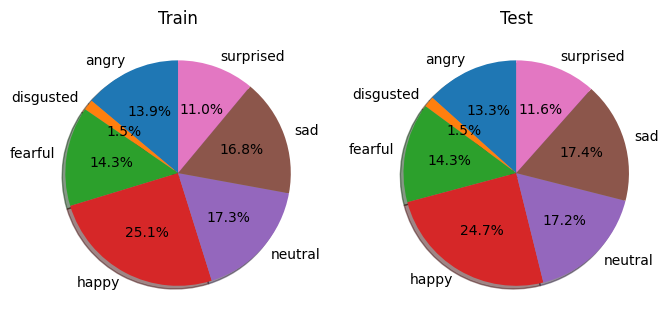

Emotion : angry
	Training : 3995
	 Testing : 958
Emotion : disgusted
	Training : 436
	 Testing : 111
Emotion : fearful
	Training : 4097
	 Testing : 1024
Emotion : happy
	Training : 7215
	 Testing : 1774
Emotion : neutral
	Training : 4965
	 Testing : 1233
Emotion : sad
	Training : 4830
	 Testing : 1247
Emotion : surprised
	Training : 3171
	 Testing : 831


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define target_var as the list of emotion labels (subdirectory names)
target_var = ["angry", "disgusted","fearful","happy","neutral", "sad","surprised"]  # Replace with actual subfolder names

# Check the number of images in each folder for train and test datasets
x_train = np.array([ len(os.listdir('/kaggle/input/emotion-detection-fer/train/' + i)) for i in target_var ])
x_test = np.array([ len(os.listdir('/kaggle/input/emotion-detection-fer/test/' + i)) for i in target_var ])
label = target_var

# Create pie charts to visualize the data distribution
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%', shadow=True, startangle=90)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%', shadow=True, startangle=90)
axes[0].set_title('Train')
axes[1].set_title('Test')
plt.show()

# Print the number of images in each category for train and test datasets
for i in target_var:
    print('Emotion : ' + i)
    print('\tTraining : ' + str(len(os.listdir('/kaggle/input/emotion-detection-fer/train/' + i))))
    print('\t Testing : ' + str(len(os.listdir('/kaggle/input/emotion-detection-fer/test/' + i))))


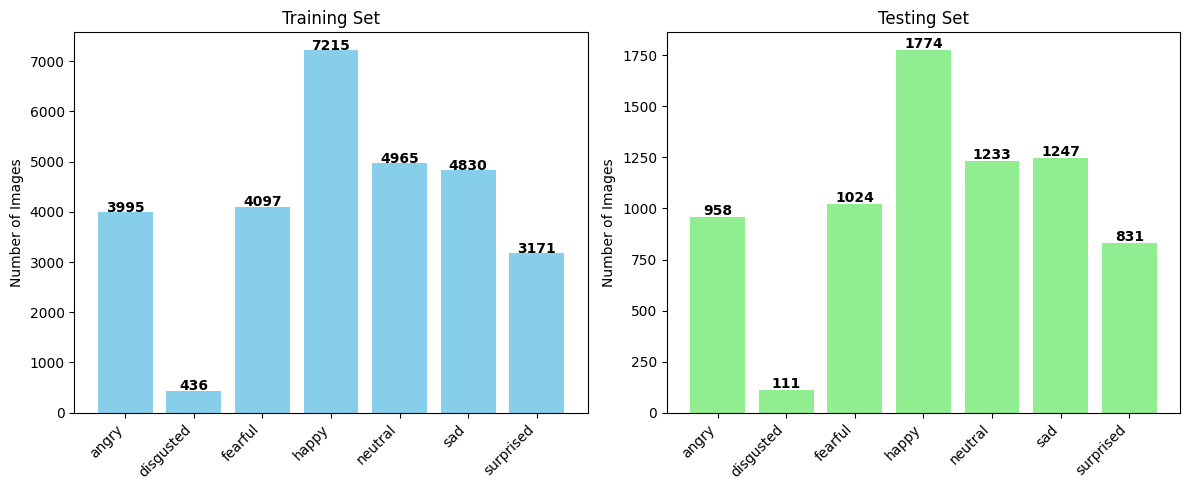

Emotion : angry
	Training : 3995
	 Testing : 958
Emotion : disgusted
	Training : 436
	 Testing : 111
Emotion : fearful
	Training : 4097
	 Testing : 1024
Emotion : happy
	Training : 7215
	 Testing : 1774
Emotion : neutral
	Training : 4965
	 Testing : 1233
Emotion : sad
	Training : 4830
	 Testing : 1247
Emotion : surprised
	Training : 3171
	 Testing : 831


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define target_var as the list of emotion labels (subdirectory names)
target_var = ["angry", "disgusted", "fearful", "happy", "neutral", "sad", "surprised"]  # Replace with actual subfolder names

# Check the number of images in each folder for train and test datasets
x_train = np.array([len(os.listdir('/kaggle/input/emotion-detection-fer/train/' + i)) for i in target_var])
x_test = np.array([len(os.listdir('/kaggle/input/emotion-detection-fer/test/' + i)) for i in target_var])
label = target_var

# Create bar charts to visualize the data distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar graph for the training set
axes[0].bar(label, x_train, color='skyblue')
axes[0].set_title('Training Set')
axes[0].set_ylabel('Number of Images')
axes[0].set_xticklabels(label, rotation=45, ha="right")

# Add the counts on top of the bars
for i, v in enumerate(x_train):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Bar graph for the testing set
axes[1].bar(label, x_test, color='lightgreen')
axes[1].set_title('Testing Set')
axes[1].set_ylabel('Number of Images')
axes[1].set_xticklabels(label, rotation=45, ha="right")

# Add the counts on top of the bars
for i, v in enumerate(x_test):
    axes[1].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Display the plots
plt.tight_layout()
plt.show()

# Print the number of images in each category for train and test datasets
for i in target_var:
    print('Emotion : ' + i)
    print('\tTraining : ' + str(len(os.listdir('/kaggle/input/emotion-detection-fer/train/' + i))))
    print('\t Testing : ' + str(len(os.listdir('/kaggle/input/emotion-detection-fer/test/' + i))))

In [ ]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
# Load VGG16 model pre-trained on ImageNet data, without top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer
predictions = Dense(7, activation='softmax')(x)  # Final output layer for 7 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary(_)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,3

 Total params: 15,247,175 (58.16 MB)

 Trainable params: 15,247,175 (58.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
loss_function = CategoricalCrossentropy()

In [ ]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=4, name = "top_k_accuracy")]

In [ ]:
model.compile(
  optimizer = Adam(learning_rate = 1e-3),
  loss = loss_function,
  metrics = metrics,
)

In [ ]:
history = model.fit(
  training_dataset,
  validation_data = validation_dataset,
  batch_size= 32,

  epochs = 20,
  verbose = 1
)

Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 84s 81ms/step - accuracy: 0.2368 - loss: 3.4319 - top_k_accuracy: 0.7230 - val_accuracy: 0.2473 - val_loss: 1.7751 - val_top_k_accuracy: 0.7625
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 68s 76ms/step - accuracy: 0.2455 - loss: 1.8171 - top_k_accuracy: 0.7351 - val_accuracy: 0.2471 - val_loss: 1.8152 - val_top_k_accuracy: 0.7353
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 68s 76ms/step - accuracy: 0.2472 - loss: 1.8125 - top_k_accuracy: 0.7355 - val_accuracy: 0.2471 - val_loss: 1.8151 - val_top_k_accuracy: 0.7353
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 83s 77ms/step - accuracy: 0.2469 - loss: 1.8127 - top_k_accuracy: 0.7352 - val_accuracy: 0.2471 - val_loss: 1.8163 - val_top_k_accuracy: 0.7261
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 95s 91ms/step - accuracy: 0.2473 - loss: 1.8136 - top_k_accuracy: 0.7351 - val_accuracy: 0.2471 - val_loss: 1.8150 - val_top_k_accuracy: 0.7261
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.2472 - loss:

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy, Precision, Recall
import tensorflow as tf

# Define metrics
metrics = [
    CategoricalAccuracy(name="accuracy"),
    TopKCategoricalAccuracy(k=4, name="top_k_accuracy"),
    Precision(name="precision"),
    Recall(name="recall"),
]

# Define a custom F1 Score function
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Add the F1 score metric
metrics.append(F1Score(name="f1_score"))

# Your model.compile() call will look something like this
# Assuming you already have your model defined
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)


In [ ]:
model.compile(
  optimizer = Adam(learning_rate = 1e-3),
  loss = loss_function,
  metrics = metrics,
)

In [ ]:
history = model.fit(
  training_dataset,
  validation_data = validation_dataset,
  batch_size= 32,

  epochs = 20,
  verbose = 1
)

Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 3573s 4s/step - accuracy: 0.2343 - f1_score: 0.0128 - loss: 2.9395 - precision: 0.1898 - recall: 0.0076 - top_k_accuracy: 0.7232 - val_accuracy: 0.2476 - val_f1_score: 0.0000e+00 - val_loss: 1.7970 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_top_k_accuracy: 0.7533
Epoch 2/20


In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation Top-4 accuracy values
plt.plot(history.history['top_k_accuracy'])
plt.plot(history.history['val_top_k_accuracy'])
plt.title('Model Top-4 Accuracy')
plt.ylabel('Top K Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation precision values
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation recall values
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation F1 score values
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
model.save('face_detection_model.h5')